##  Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import plotly.io as pio
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'plotly'

##  Loading Dataset

In [2]:
df=pd.read_csv('Covid-19_Dataset.csv')

In [3]:
df.head(2)

,id,case_in_country,reporting date,summary,location,country,gender,age,symptom_onset,If_onset_approximated,hosp_visit_date,exposure_start,exposure_end,visiting Wuhan,from Wuhan,death,recovered,symptom,source,link
0,765,15.0,02-10-20,new confirmed COVID-19 patient in Vietnam: 3 m...,Vinh Phuc,Vietnam,NaN,0.25,NaN,NaN,NaN,NaN,NaN,0,0,0,1,NaN,Vietnam News,https://vietnamnews.vn/society/591803/viet-nam...
1,477,27.0,02-05-20,new confirmed COVID-19 patient in Singapore: m...,Singapore,Singapore,male,0.50,NaN,NaN,NaN,1/23/2020,02-03-20,0,0,0,1,NaN,Straits Times,https://www.straitstimes.com/singapore/health/...


In [53]:
df.shape

(1085, 20)

In [54]:
df.dtypes

id                         int64
case_in_country          float64
reporting date            object
summary                   object
location                  object
country                   object
gender                    object
age                      float64
symptom_onset             object
If_onset_approximated    float64
hosp_visit_date           object
exposure_start            object
exposure_end              object
visiting Wuhan             int64
from Wuhan                 int64
death                      int64
recovered                  int64
symptom                   object
source                    object
link                      object
dtype: object

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1085 non-null   int64  
 1   case_in_country        888 non-null    float64
 2   reporting date         1084 non-null   object 
 3   summary                1080 non-null   object 
 4   location               1085 non-null   object 
 5   country                1085 non-null   object 
 6   gender                 902 non-null    object 
 7   age                    843 non-null    float64
 8   symptom_onset          563 non-null    object 
 9   If_onset_approximated  560 non-null    float64
 10  hosp_visit_date        507 non-null    object 
 11  exposure_start         128 non-null    object 
 12  exposure_end           341 non-null    object 
 13  visiting Wuhan         1085 non-null   int64  
 14  from Wuhan             1085 non-null   int64  
 15  deat

##  Data Cleaning

First we remove unnecessary columns.

In [56]:
df.drop(['id','case_in_country','summary','symptom_onset', 'If_onset_approximated', 'hosp_visit_date', 'exposure_start',
'exposure_end', 'symptom', 'source', 'link'],axis=1,inplace=True)

In [57]:
100*df.isnull().sum()/df.shape[0]

reporting date     0.092166
location           0.000000
country            0.000000
gender            16.866359
age               22.304147
visiting Wuhan     0.000000
from Wuhan         0.000000
death              0.000000
recovered          0.000000
dtype: float64

In [58]:
df['age']= df['age']. fillna(df['age'].mean())

In [59]:
df_dum=pd.get_dummies(df['gender'].dropna(), drop_first=True)

In [60]:
df_dum['male'].median()

1.0

So we fill the null values in gender column with 'male'.

In [61]:
df['gender']= df['gender']. fillna('male')

Fianlly the columns that contain less than 0.5% null values are remained, and we drop the rows of df that contain these null values.

In [62]:
df.dropna(inplace=True)

In [63]:
df.isnull().sum()

reporting date    0
location          0
country           0
gender            0
age               0
visiting Wuhan    0
from Wuhan        0
death             0
recovered         0
dtype: int64

##  Feature Engineering

We rename some of the columns.

In [64]:
df.columns=df.columns.str.lower().str.replace(' ','_')

Now we change the format of date and add month column to df.

In [65]:
df['reporting_date']=pd.to_datetime(df['reporting_date'])

In [66]:
df['year']=df['reporting_date'].apply(lambda x:x.year)
df['month']=df['reporting_date'].apply(lambda x:x.month)

In [67]:
df['month'].unique()

array([2, 1], dtype=int64)

As there is only one year, we can remove the year column.

In [68]:
df.drop(['reporting_date', 'year'], axis=1, inplace=True)

In [69]:
df.head(2)

,location,country,gender,age,visiting_wuhan,from_wuhan,death,recovered,month
0,Vinh Phuc,Vietnam,male,0.25,0,0,0,1,2
1,Singapore,Singapore,male,0.50,0,0,0,1,2


##  Exploratory Data Analysis

We want to find the number of patients died and recovered based on their age.

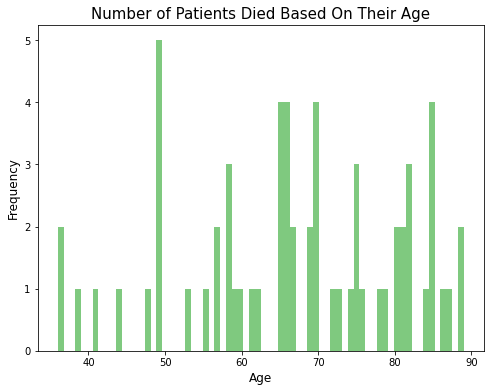

In [70]:
plt.figure(figsize=(8,6))
df[df['death']==1]['age'].plot(kind='hist',bins=70,colormap='Accent')
plt.title('Number of Patients Died Based On Their Age',fontsize=15)
plt.xlabel('Age',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.show()

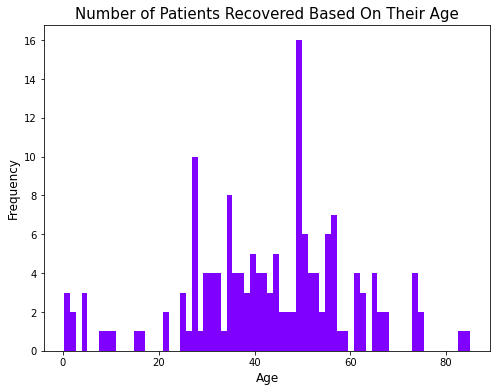

In [71]:
plt.figure(figsize=(8,6))
df[df['recovered']==1]['age'].plot(kind='hist',bins=70,colormap='rainbow')
plt.title('Number of Patients Recovered Based On Their Age',fontsize=15)
plt.xlabel('Age',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.show()

In [72]:
print('Current count of patients:',df['death'].count())
print('Number of Dead Patients:', df[df['death']==1]['death'].count())
print('Number of Recovered Patients:',df[df['recovered']==1]['death'].count())
print('Number of Patients Receiving Treatment:',df[(df['death']==0)&(df['recovered']==0)]['death'].count())

Current count of patients: 1084
Number of Dead Patients: 63
Number of Recovered Patients: 159
Number of Patients Receiving Treatment: 862


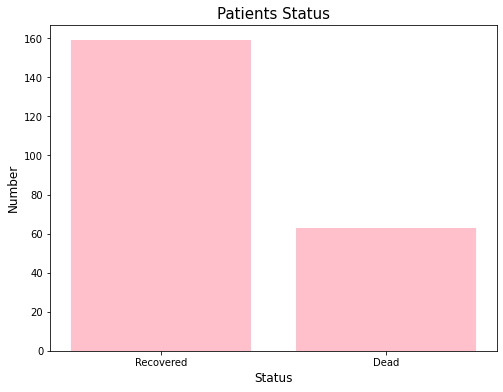

In [73]:
plt.figure(figsize=(8,6))
plt.bar(x=['Recovered','Dead'],height=[159,63], color='pink')
plt.title('Patients Status',fontsize=15)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Number',fontsize=12)
plt.show()

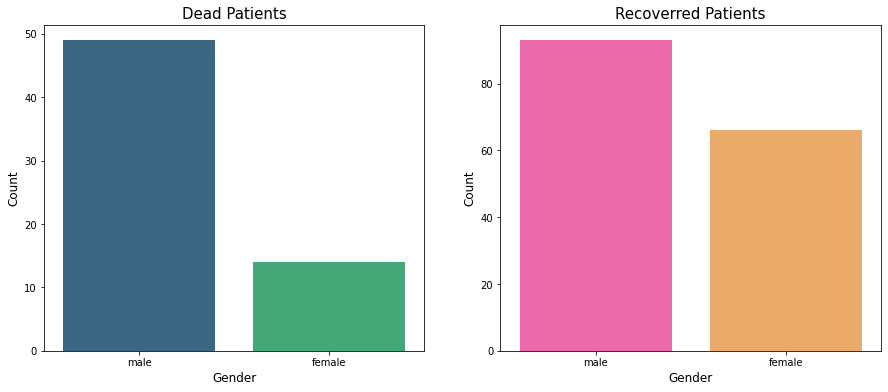

In [74]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='gender', data=df[df['death']==1], palette='viridis')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Dead Patients',fontsize=15)
plt.subplot(1,2,2)
sns.countplot(x='gender', data=df[df['recovered']==1], palette='spring')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Recoverred Patients',fontsize=15)
plt.show()

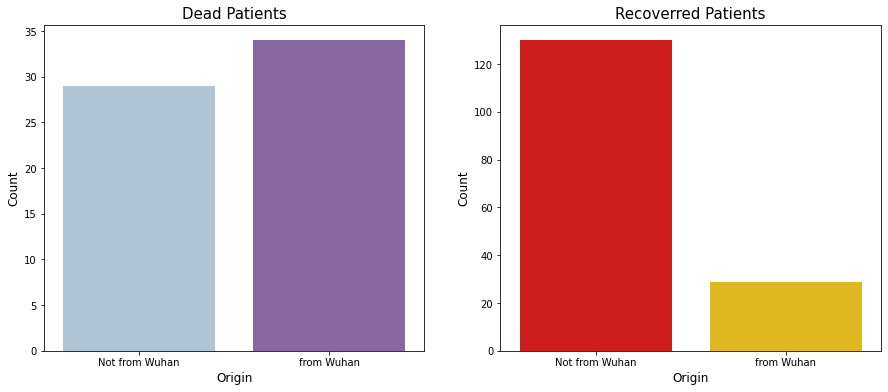

In [75]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='from_wuhan', data=df[df['death']==1], palette='BuPu')
plt.xticks([0,1], ['Not from Wuhan','from Wuhan'])
plt.xlabel('Origin', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Dead Patients',fontsize=15)
plt.subplot(1,2,2)
sns.countplot(x='from_wuhan', data=df[df['recovered']==1], palette='hot')
plt.xticks([0,1], ['Not from Wuhan','from Wuhan'])
plt.xlabel('Origin', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Recoverred Patients',fontsize=15)
plt.show()

In [76]:
country_order=list(df.groupby('country').count()['location'].sort_values(ascending=False).index)

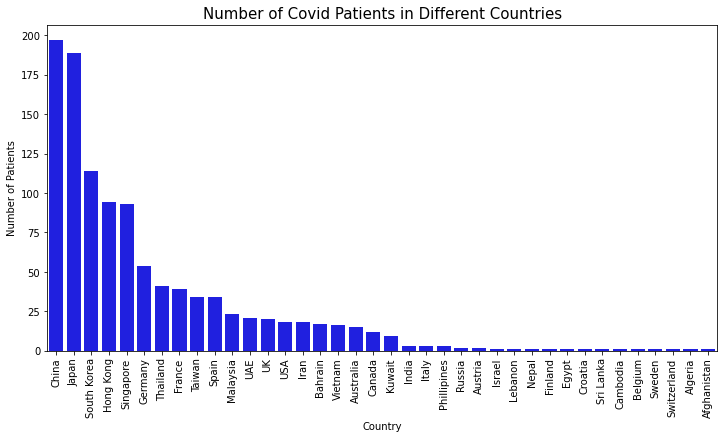

In [77]:
plt.figure(figsize=(12,6))
sns.countplot(x='country',data=df,color='blue',order=country_order)
plt.xticks(rotation=90)
plt.ylabel('Number of Patients')
plt.xlabel('Country')
plt.title('Number of Covid Patients in Different Countries',fontsize=15)
plt.show()

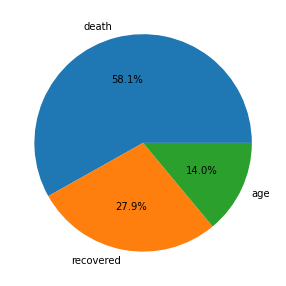

In [78]:
labels = ["death","recovered","age"]
values = [500,240,120]

f,ax = plt.subplots(figsize=(10, 5))
plt.pie(values, labels = labels,autopct='%1.1f%%')
plt.show()

In [79]:
groupby_df=df.groupby('country').sum()

##  Prediction of Death or Recovery of Patients

### Label Encoding

**Location**

In [80]:
le1=LabelEncoder()
le1.fit(df['location'])
df['location']=le1.transform(df['location'])

**Country**

In [81]:
le2=LabelEncoder()
le2.fit(df['country'])
df['country']=le2.transform(df['country'])

**Gender**

In [82]:
le3=LabelEncoder()
le3.fit(df['gender'])
df['gender']=le3.transform(df['gender'])

In [83]:
df.head()

,location,country,gender,age,visiting_wuhan,from_wuhan,death,recovered,month
0,141,37,1,0.25,0,0,0,1,2
1,118,26,1,0.50,0,0,0,1,2
2,118,26,1,1.00,0,0,0,1,2
3,42,8,0,2.00,1,0,0,0,1
4,60,22,1,2.00,0,0,0,1,1


###  Predicting the Recovery

####  Splitting the Data

In [84]:
y=df['recovered']
X=df[['location','country','gender','age','visiting_wuhan','from_wuhan','month']]

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

####  Random Forest Classifier

In [86]:
rfc1=RandomForestClassifier(n_estimators=200)
rfc1.fit(X_train,y_train)
predictions_rfc1=rfc1.predict(X_test)
predictions_rfc1

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
      dtype=int64)

In [87]:
print(confusion_matrix(y_test,predictions_rfc1))
print('\n')
print(classification_report(y_test,predictions_rfc1))

[[178   7]
 [ 13  19]]


              precision    recall  f1-score   support

           0       0.93      0.96      0.95       185
           1       0.73      0.59      0.66        32

    accuracy                           0.91       217
   macro avg       0.83      0.78      0.80       217
weighted avg       0.90      0.91      0.90       217



In [88]:
rf_recovery_acc = accuracy_score(y_test,predictions_rfc1)
rf_recovery_acc

0.9078341013824884

###  Predicting the Death

#### Splitting the Data

In [89]:
y=df['death']
X=df[['location','country','gender','age','visiting_wuhan','from_wuhan','month']]

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=110)

####  Random Forest Classifier

In [91]:
rfc2=RandomForestClassifier(n_estimators=200)
rfc2.fit(X_train,y_train)
predictions_rfc2=rfc2.predict(X_test)
predictions_rfc2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [92]:
print(confusion_matrix(y_test,predictions_rfc2))
print('\n')
print(classification_report(y_test,predictions_rfc2))

[[202   1]
 [  9   5]]


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       203
           1       0.83      0.36      0.50        14

    accuracy                           0.95       217
   macro avg       0.90      0.68      0.74       217
weighted avg       0.95      0.95      0.95       217



In [93]:
rf_death_acc = accuracy_score(y_test,predictions_rfc2)
rf_death_acc

0.9539170506912442